# <div align="center">Aim of the code</div>

1) To extract the XRD data from multiple .cif files.
2) To generate the data for neural network, X_train and Y_train. <br>
X_train will contain all the intensity values (scaled between 0 and 1) and Y_train will contain the corresponding lattice parameters (a, b,c, alpha, beta, gamma).
3) Clean the data.
3) Save the X_train and Y_train numpy arrays as two seperate .csv files

## Note:

We will train our model only for P-1 space group

# Libraries

In [1]:
import os

# import the library for manimulating cif data
import Dans_Diffraction as dif               # "pip install Dans-Diffraction" for installing this package

import numpy as np

# Create a list containing names of all the .cif files

In [2]:
# Create an empty list to store the paths of all .cif files
file_paths = []

training_data_directory = './cif_files/training/'             # ./ means current directory

for file in os.listdir(training_data_directory):
    if ".cif" in file:
        file_paths.append('./cif_files/training/' + file)

In [3]:
len(file_paths)

1798

In [5]:
file_paths[0:5]

['./cif_files/mixture/1000004.cif',
 './cif_files/mixture/1000023.cif',
 './cif_files/mixture/1000025.cif',
 './cif_files/mixture/1000026.cif',
 './cif_files/mixture/1000027.cif']

# Create a function to generate numpy arrays, X_train and Y_train for machine learning

In [6]:
def generate_data(file):
    
    # define relevant parameters
    energy_kev = dif.fc.wave2energy(1.54059)

    xtl = dif.Crystal(file);         # ; suppresses the output a given line of code

    # get the lattice parameters, a,b,c, and alpha, beta, gamma
    lattice_parameters = xtl.Cell.lp();

    # get the 2theta, corresponding intensities, and reflections (h,k, l values (Miler indices)

    xtl.Scatter.setup_scatter(energy_kev=energy_kev, min_twotheta=5, max_twotheta=100, scattering_type='xray', powder_units='tth');
    twotheta, intensity, reflections = xtl.Scatter.powder(units='tth', peak_width=0.01, background=0);

    # since we don't need the reflections and twotheta we can delete it from memory to save RAM
    del(twotheta, reflections)

    # scale the intensity between 0 and 1
    intensity /= np.max(intensity);


    # We don't need all of the points so we will skip some of the 2theta values
    intensity = intensity[0:intensity.size:10]

    # Create an empty list to store X_train
    X_train = []

    # Create an empty list to store Y_train
    Y_train = []
                            
    # create X_train containing intensity values for all two theta along a row.
    X_train = intensity;
    Y_train = list(lattice_parameters);

    del(intensity)        # delete the intensity matrix at the end to clear up RAM
    
    return X_train, Y_train


# Run the "generate_data" function in parallel for different .cif files

In [7]:
%%capture
# The above line of code supresses the output of this entire cell

from joblib import Parallel, delayed

data = Parallel(n_jobs = -1, max_nbytes=None, timeout=None, backend= 'loky')(delayed(generate_data)(file) for file in file_paths)


## Partition the data into X_train and Y_train

In [8]:
X_train, Y_train = zip(*data)

# convert both of them into numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# delete the data array
del(data)

# Check the shape of X_train and Y_train
print(X_train.shape, Y_train.shape)

(1798, 1179) (1798, 6)


# Check if data is correctly generated

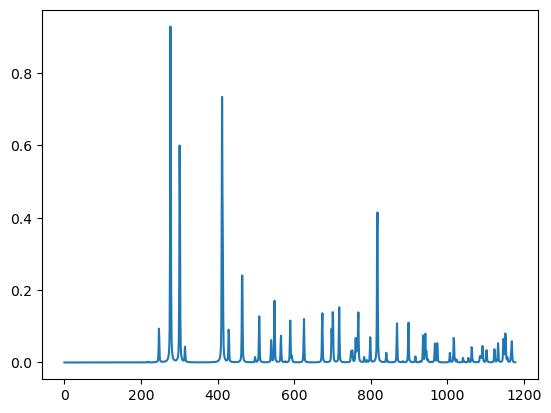

In [9]:
import matplotlib.pyplot as plt

plt.plot(X_train[4])

# Save the X_train data as a single .csv file

In [10]:
import pandas as pd

df_1 = pd.DataFrame(X_train)
df_2 = pd.DataFrame(Y_train)

df_1.to_csv('./training_data/X_train.csv', index=False, header=False)
df_2.to_csv('./training_data/Y_train.csv', index=False, header=False)

# Check for exceptional points in the data

In [11]:
# import the data from the saved file

X_train = np.genfromtxt('./training_data/X_train.csv', delimiter=',')

Y_train = np.genfromtxt('./training_data/Y_train.csv', delimiter=',')


In [32]:
Y_train

array([[  9.899  ,  11.729  ,  12.259  , 103.442  ,  96.291  ,  95.56   ],
       [  7.9296 ,   9.3275 ,   6.2555 , 107.16   , 101.011  , 105.83   ],
       [  3.8203 ,   3.88548,  11.68349,  90.     ,  90.     ,  90.     ],
       ...,
       [  3.936  ,   6.153  ,   3.656  ,  90.     ,  90.     ,  90.     ],
       [  3.9147 ,   3.8672 ,  11.7033 ,  90.     ,  90.     ,  90.     ],
       [  3.8646 ,   3.8688 ,  11.6392 ,  90.     ,  90.     ,  90.     ]])

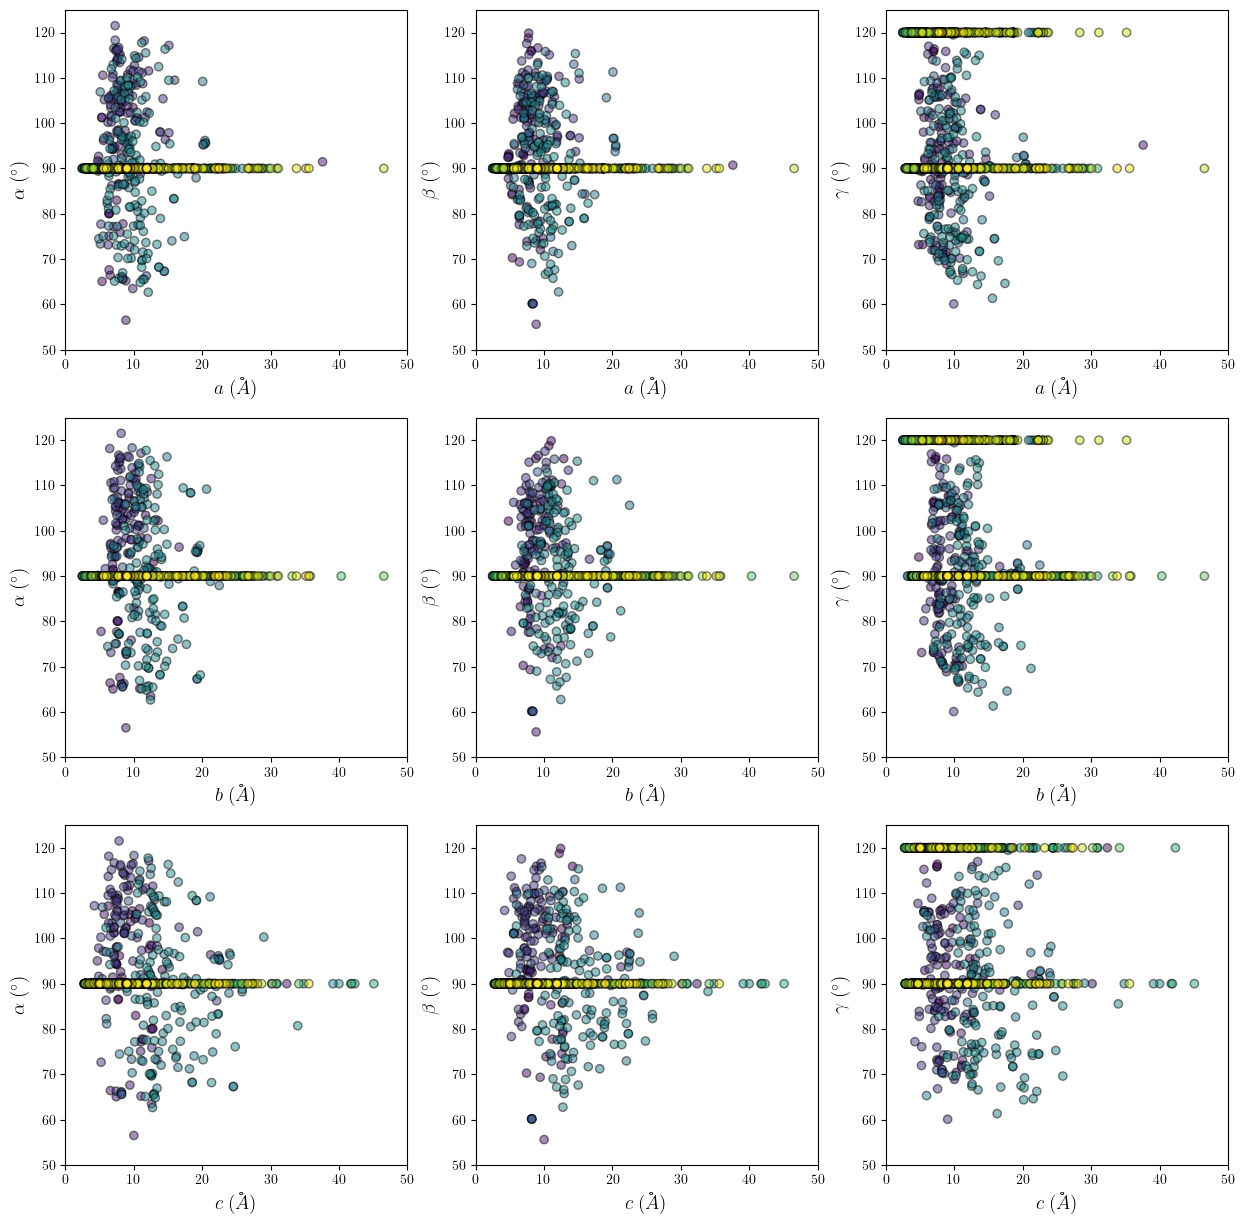

In [13]:
def plot_data(data):
    import matplotlib.pyplot as plt
    plt.rcParams['text.usetex'] = True


    fig, axs = plt.subplots(nrows=3, ncols=3, figsize = (15,15))

    plt.setp(axs, xlim=(0, 50), ylim=(50, 125))         # set a common xlimit and ylimit for all subplots

    colors = np.arange(data[:,0].size)                  # colors are set such a way that the first point plotted will be the darkest and last point plotted will be lightest

    for i in range(3):
        axs[0,i].set_xlabel(r'$a\; (\r{A})$', fontsize = 14)
        axs[1,i].set_xlabel(r'$b\; (\r{A})$', fontsize = 14)
        axs[2,i].set_xlabel(r'$c\; (\r{A})$', fontsize = 14)

    for i in range(3):
        axs[i,0].set_ylabel(r'$\alpha\; (^{\circ})$', fontsize = 14)
        axs[i,1].set_ylabel(r'$\beta\; (^{\circ})$', fontsize = 14)
        axs[i,2].set_ylabel(r'$\gamma\; (^{\circ})$', fontsize = 14)

    axs[0,0].scatter(data[:, 0], data[:, 3], c=colors, cmap = 'viridis', edgecolor = 'black', alpha = 0.5)      # alpha  determins the transperancy. 
                                                                                                                # edgecolor determines the color of marker border
    axs[0,1].scatter(data[:, 0], data[:, 4], c=colors, edgecolor = 'black', alpha = 0.5)
    axs[0,2].scatter(data[:, 0], data[:, 5], c=colors, edgecolor = 'black', alpha = 0.5)


    axs[1,0].scatter(data[:, 1], data[:, 3], c=colors, edgecolor = 'black', alpha = 0.5)
    axs[1,1].scatter(data[:, 1], data[:, 4], c=colors, edgecolor = 'black', alpha = 0.5)
    axs[1,2].scatter(data[:, 1], data[:, 5], c=colors, edgecolor = 'black', alpha = 0.5)

    axs[2,0].scatter(data[:, 2], data[:, 3], c=colors, edgecolor = 'black', alpha = 0.5)
    axs[2,1].scatter(data[:, 2], data[:, 4], c=colors, edgecolor = 'black', alpha = 0.5)
    axs[2,2].scatter(data[:, 2], data[:, 5], c=colors, edgecolor = 'black', alpha = 0.5)

    plt.show()

plot_data(Y_train)    


It can be seen in the first row, there is a single isolated point, we should be able to neglect such data.

# Check how $a$, $b$, and $c$ are corelated

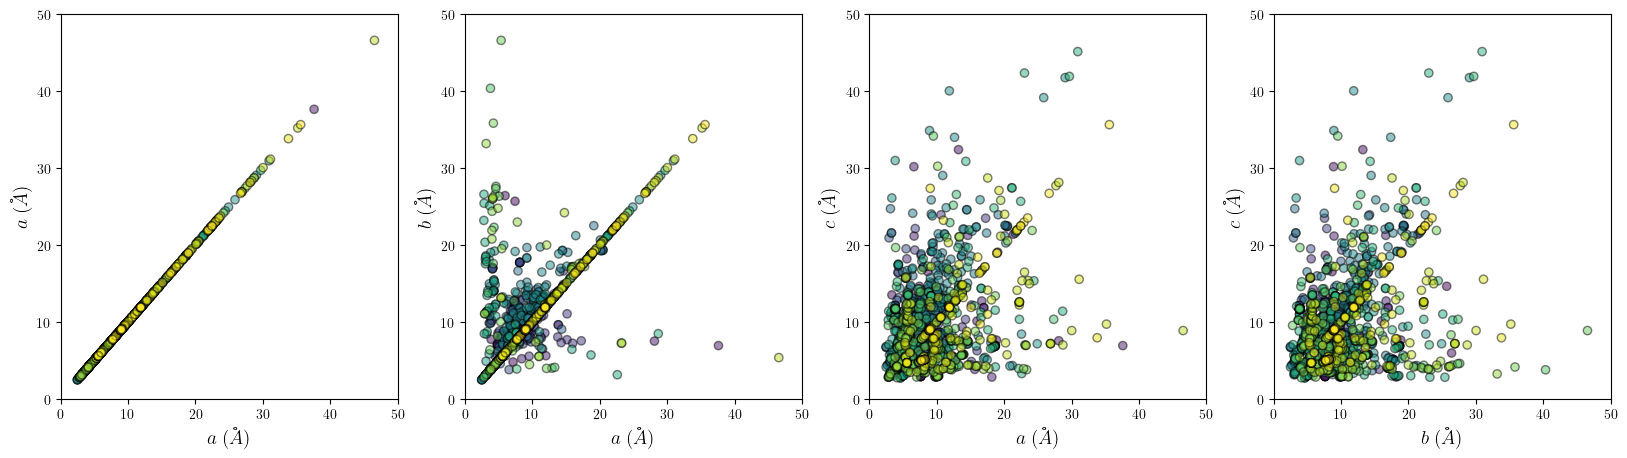

In [14]:
def plot_correlation_between_lattice_params(data):
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize = (20,5))

    plt.setp(axs, xlim=(0, 50), ylim=(0, 50))         # set a common xlimit and ylimit for all subplots

    colors = np.arange(data[:,0].size)                  # colors are set such a way that the first point plotted will be the darkest and last point plotted will be lightest


    for i in range(3):
        axs[i].set_xlabel(r'$a\; (\r{A})$', fontsize = 14)

    axs[0].set_ylabel(r'$a\; (\r{A})$', fontsize = 14)
    axs[1].set_ylabel(r'$b\; (\r{A})$', fontsize = 14)
    axs[2].set_ylabel(r'$c\; (\r{A})$', fontsize = 14)

    axs[0].scatter(data[:, 0], data[:, 0], c=colors, cmap = 'viridis', edgecolor = 'black', alpha = 0.5)      # alpha  determins the transperancy.                                                                                                         # edgecolor determines the color of marker border
    axs[1].scatter(data[:, 0], data[:, 1], c=colors, edgecolor = 'black', alpha = 0.5)
    axs[2].scatter(data[:, 0], data[:, 2], c=colors, edgecolor = 'black', alpha = 0.5)
    
    axs[3].set_xlabel(r'$b\; (\r{A})$', fontsize = 14)
    axs[3].set_ylabel(r'$c\; (\r{A})$', fontsize = 14)
    axs[3].scatter(data[:, 1], data[:, 2], c=colors, edgecolor = 'black', alpha = 0.5)

    plt.show()

plot_correlation_between_lattice_params(Y_train)    

# Delete exceptional points

In [12]:
# delete rows in the data for which a>17
##################################################
row_number = np.where(Y_train[:,0] >25);
X_train_new = np.delete(X_train, row_number, 0);
Y_train_new = np.delete(Y_train, row_number, 0);


# delete rows in the data for which b>20
##################################################
row_number = np.where(Y_train_new[:,1] >20);
X_train_new = np.delete(X_train_new, row_number, 0);
Y_train_new = np.delete(Y_train_new, row_number, 0);


# delete rows in the data for which c>27
##################################################
row_number = np.where(Y_train_new[:,2] >27);
X_train_new = np.delete(X_train_new, row_number, 0);
Y_train_new = np.delete(Y_train_new, row_number, 0);

# delete rows in the data for which alpha<60
##################################################
row_number = np.where(Y_train_new[:,3] <60);          # alpha should no be less than 60
X_train_new = np.delete(X_train_new, row_number, 0);
Y_train_new = np.delete(Y_train_new, row_number, 0);

# delete rows in the data for which alpha>120
##################################################
row_number = np.where(Y_train_new[:,3] >120);          # alpha should no be greater than 120
X_train_new = np.delete(X_train_new, row_number, 0);
Y_train_new = np.delete(Y_train_new, row_number, 0);

# delete rows in the data for which beta<60
##################################################
row_number = np.where(Y_train_new[:,4] <60);
X_train_new = np.delete(X_train_new, row_number, 0);
Y_train_new = np.delete(Y_train_new, row_number, 0);


# delete rows in the data for which beta>120
##################################################
row_number = np.where(Y_train_new[:,4] >120); 
X_train_new = np.delete(X_train_new, row_number, 0);
Y_train_new = np.delete(Y_train_new, row_number, 0);


# delete rows in the data for which gamma<60
##################################################
row_number = np.where(Y_train_new[:,5] <60);
X_train_new = np.delete(X_train_new, row_number, 0);
Y_train_new = np.delete(Y_train_new, row_number, 0);


# delete rows in the data for which gamma>120
##################################################
row_number = np.where(Y_train_new[:,5] >120);
X_train_new = np.delete(X_train_new, row_number, 0);
Y_train_new = np.delete(Y_train_new, row_number, 0);


Y_train_new.shape

(792, 6)

# replot the data to check whether the exceptional points got deleted

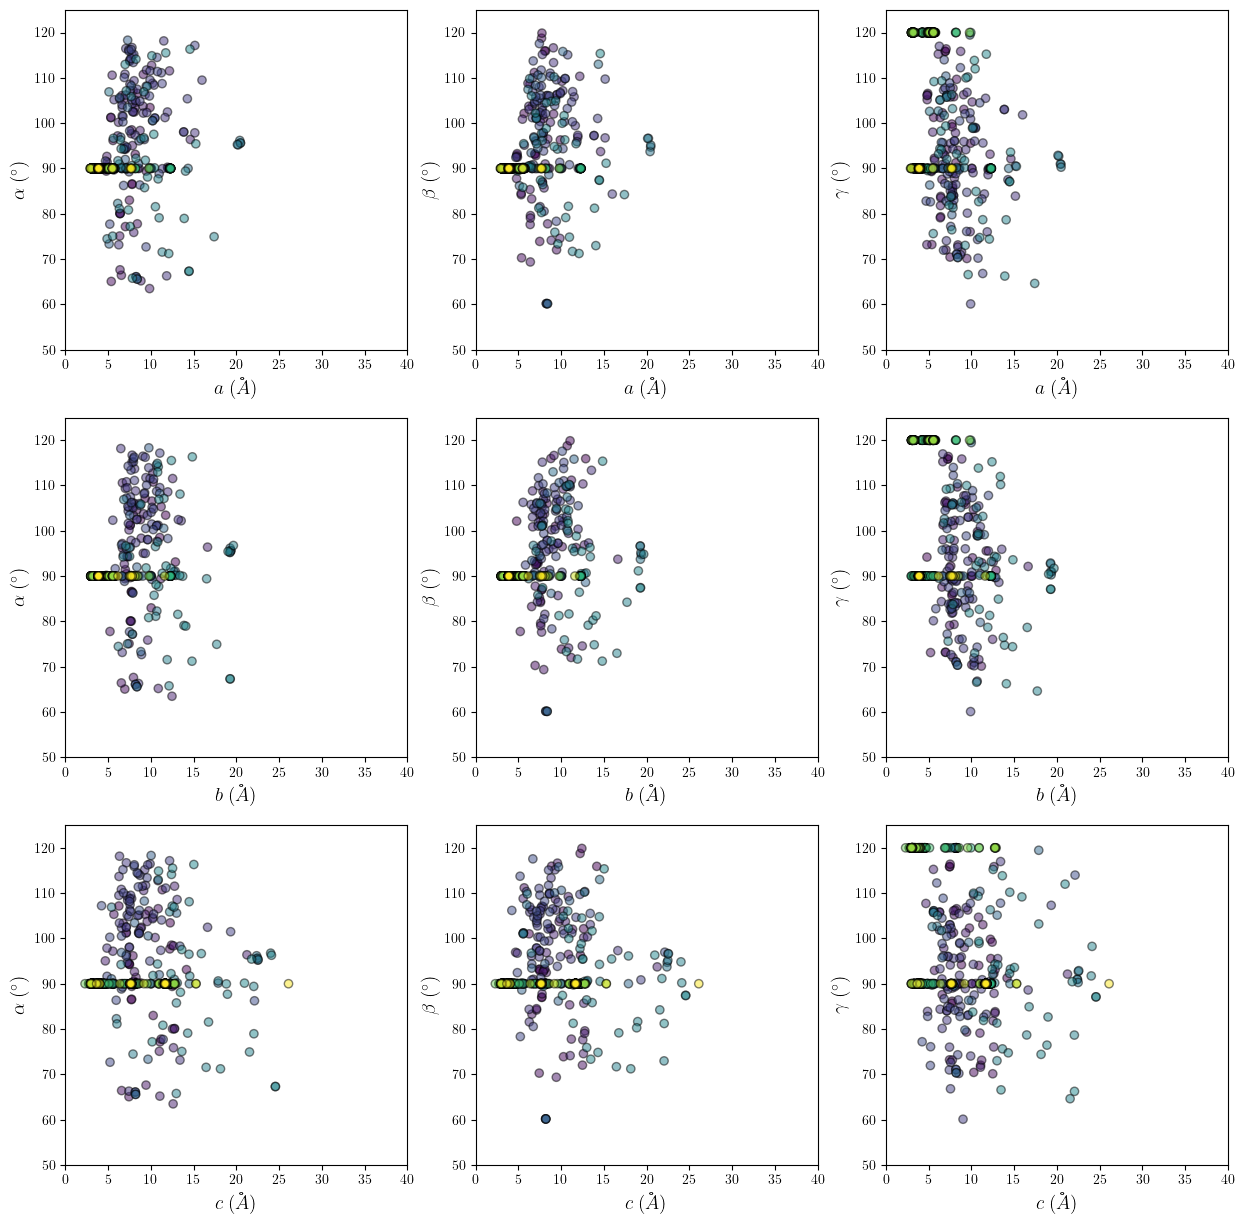

In [13]:
plot_data(Y_train_new)    

# recheck corelation between $a$, $b$, and $c$

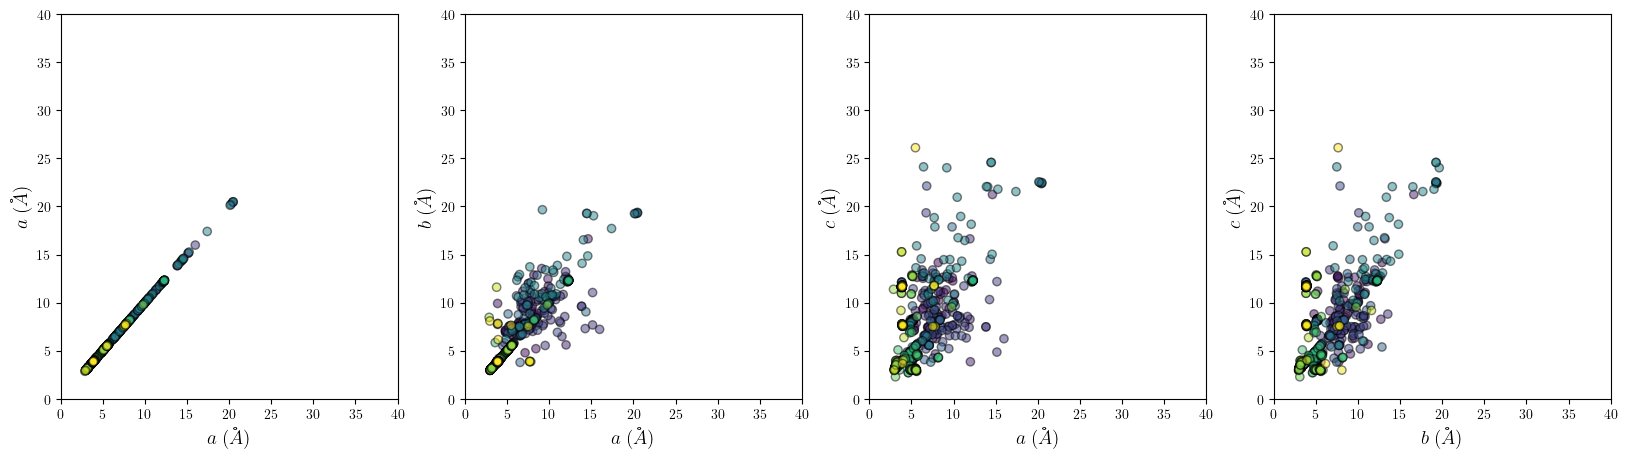

In [14]:
plot_correlation_between_abc(Y_train_new)  

# Save the X_train_new and X_train_new to a .csv file

In [70]:
df_1 = pd.DataFrame(X_train_new)
df_2 = pd.DataFrame(Y_train_new)

df_1.to_csv('./training_data/cleaned_training_data/X_train.csv', index=False, header=False)
df_2.to_csv('./training_data/cleaned_training_data/Y_train.csv', index=False, header=False)